### 1. Chuẩn bị dữ liệu

In [1]:
from tensorflow import keras 
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
df =pd.read_csv(r"C:\Users\NGUYEN MINH TUYET\Stock pj\stock_prices_all.csv")
print(df.head())
print(df.info())
print(df.describe())

                      time   open   high    low  close   volume symbol
0  2025-10-10 00:00:00.000   8.23   8.28   8.15   8.22  1530500    AAA
1  2025-10-10 00:00:00.000  11.30  11.40  11.20  11.30   140600    ABW
2  2025-10-10 00:00:00.000   4.00   4.10   3.90   4.00   692400    AAH
3  2025-10-10 00:00:00.000  19.10  19.10  19.00  19.00     1100    ADC
4  2025-10-10 00:00:00.000   9.47   9.47   9.12   9.42     5400    ADG
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853865 entries, 0 to 853864
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    853865 non-null  object 
 1   open    853865 non-null  float64
 2   high    853865 non-null  float64
 3   low     853865 non-null  float64
 4   close   853865 non-null  float64
 5   volume  853865 non-null  int64  
 6   symbol  853865 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 45.6+ MB
None
                open           high            low    

In [3]:
symbol = "ACB"

# Lọc dữ liệu theo symbol
data = df[df["symbol"] == symbol].copy()

# Sắp xếp theo time
data = data.sort_values("time")

# Reset index và đặt tên
data = data.reset_index(drop=True)
data.index.name = "index"
data['time'] = pd.to_datetime(data['time'], errors='coerce').dt.date

data = data.rename(columns={"time": "date", "symbol":"name"})

data.head()

,date,open,high,low,close,volume,name
index,,,,,,,
0,2020-01-02,6.58,6.64,6.55,6.64,1163109,ACB
1,2020-01-03,6.64,6.70,6.61,6.64,1055528,ACB
2,2020-01-06,6.64,6.64,6.49,6.49,1286035,ACB
3,2020-01-07,6.49,6.55,6.49,6.49,1050934,ACB
4,2020-01-08,6.49,6.49,6.35,6.38,2304937,ACB


### 2. Tổng quan dữ liệu

#### 2.1. Mô tả dữ liệu

In [4]:
print(data.head())
print(data.info())
print(data.describe())

             date  open  high   low  close   volume name
index                                                   
0      2020-01-02  6.58  6.64  6.55   6.64  1163109  ACB
1      2020-01-03  6.64  6.70  6.61   6.64  1055528  ACB
2      2020-01-06  6.64  6.64  6.49   6.49  1286035  ACB
3      2020-01-07  6.49  6.55  6.49   6.49  1050934  ACB
4      2020-01-08  6.49  6.49  6.35   6.38  2304937  ACB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1436 non-null   object 
 1   open    1436 non-null   float64
 2   high    1436 non-null   float64
 3   low     1436 non-null   float64
 4   close   1436 non-null   float64
 5   volume  1436 non-null   int64  
 6   name    1436 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 78.7+ KB
None
              open         high          low        close        volume
count  1436.000000  14

#### 2.2. Biểu diễn giá mở cửa và đóng cửa

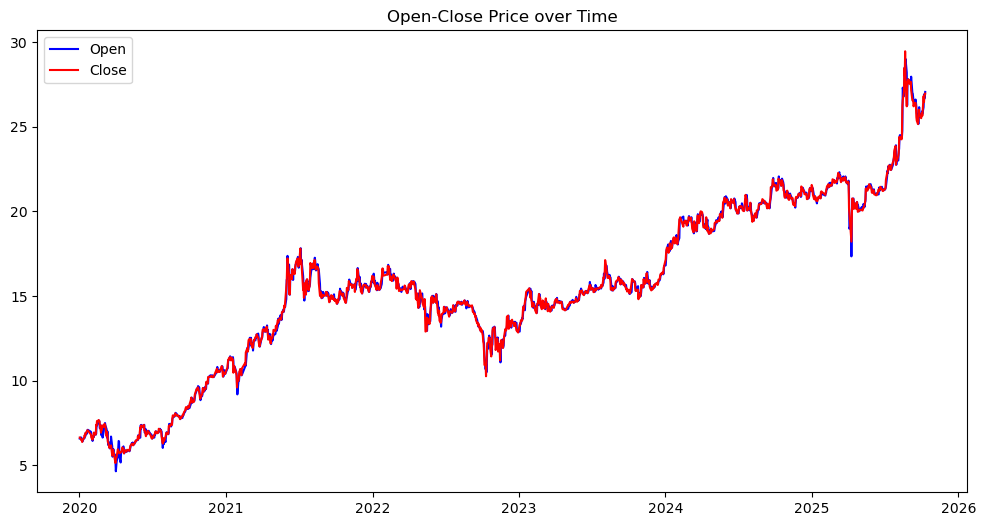

In [5]:
plt.figure(figsize=(12,6))
plt.plot(data['date'], data['open'], label="Open",color="blue")
plt.plot(data['date'], data['close'], label="Close",color="red")
plt.title("Open-Close Price over Time")
plt.legend()
plt.show()

#### 2.3. Lưu lượng giao dịch (check ngoại lai)

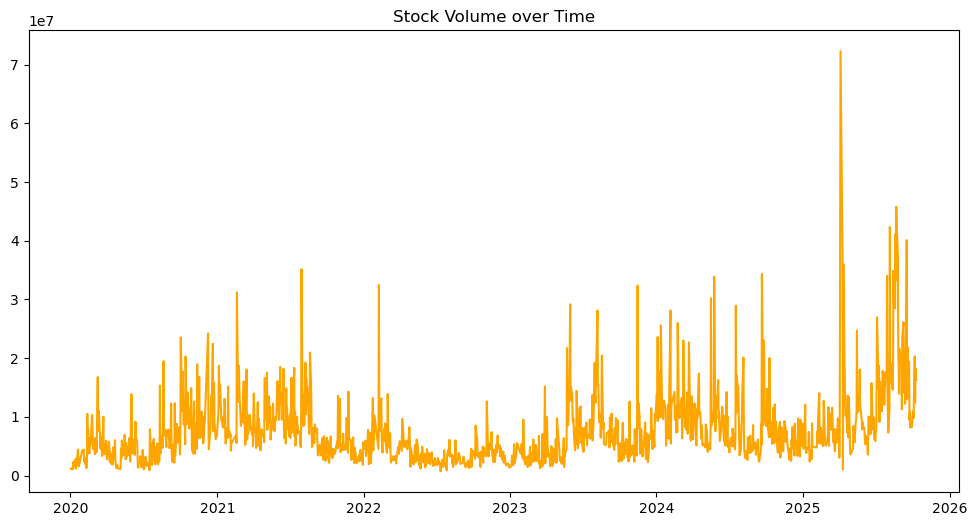

In [6]:
plt.figure(figsize=(12,6))
plt.plot(data['date'],data['volume'],label="Volume",color="orange")
plt.title("Stock Volume over Time")
plt.show()

In [7]:
#Tính IQR để phát hiện outliers trong volume
q25, q75 = np.percentile(data['volume'], 25), np.percentile(data['volume'], 75)
iqr = q75 - q25
iqr

np.float64(5616892.0)

In [8]:
#Tính giá trị biên để xác định outliers
limit_iqr = 1.5*iqr
lower_iqr, upper_iqr = q25 - limit_iqr, q75 + limit_iqr

In [9]:
#Xác định outliers
ouliers_index_iqr = [x for x in data['volume'] if x < lower_iqr or x > upper_iqr]
print('Number of outliers: %d' % len(ouliers_index_iqr))

Number of outliers: 75


In [10]:
# Loại bỏ outliers
data = data[~data['volume'].isin(ouliers_index_iqr)]
print(f"Number of Non-outliers: {len(data)}")

Number of Non-outliers: 1361


In [11]:
# Drop non-numeric columns
numeric_data = data.select_dtypes(include=["int64","float64"])

#### 2.4. Kiểm tra tính tương quan

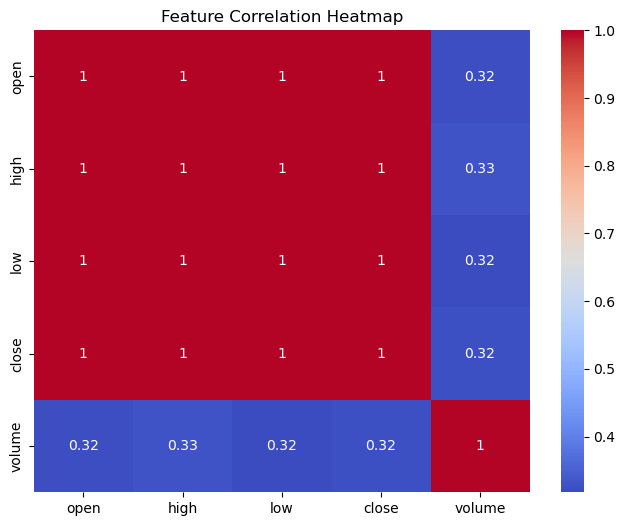

In [12]:
# Plot 3 - Check for correlation between features
plt.figure(figsize=(8,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

*=> Các biến giá có tương quan mạnh, phù hợp cho dự đoán; volume có thể bổ sung nhưng không chủ đạo.*

#### 2.5. Chuyển định dạng thời gian về datetime

Text(0.5, 1.0, 'Price over time')

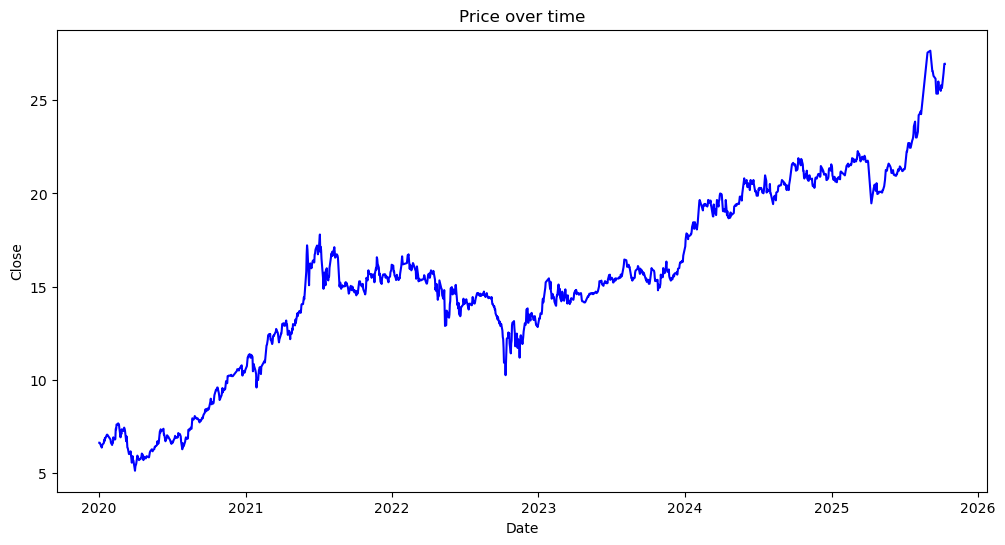

In [13]:
# Convert the Data into Date time then create a date filter
data['date'] = pd.to_datetime(data['date'])

prediction = data.loc[
    (data['date'] > datetime(2020,1,1)) &
    (data['date'] < datetime(2026,1,1))
]

plt.figure(figsize=(12,6))
plt.plot(data['date'], data['close'],color="blue")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Price over time")

## 3. Dự đoán với ARIMA
### 3.1. Chuẩn bị dữ liệu cho ARIMA

In [14]:
ts = data.set_index('date')['close'] 
ts = ts.asfreq('D')  # Chuyển đổi tần suất dữ liệu theo ngày
ts = ts.fillna(method='ffill')  # Fill NaN values with forward fill với các ngày là outliers

ts.head()

C:\Users\NGUYEN MINH TUYET\AppData\Local\Temp\ipykernel_15300\3318744525.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.fillna(method='ffill')  # Fill NaN values with forward fill với các ngày là outliers


date
2020-01-02    6.64
2020-01-03    6.64
2020-01-04    6.64
2020-01-05    6.64
2020-01-06    6.49
Freq: D, Name: close, dtype: float64

In [15]:
arima_train_size = int(len(ts) * 0.8)

arima_train = ts.iloc[:arima_train_size]
arima_test = ts.iloc[arima_train_size:]

print("Train size:", len(arima_train))
print("Test size:", len(arima_test))

arima_train.head(), arima_test.head()

Train size: 1687
Test size: 422


(date
 2020-01-02    6.64
 2020-01-03    6.64
 2020-01-04    6.64
 2020-01-05    6.64
 2020-01-06    6.49
 Freq: D, Name: close, dtype: float64,
 date
 2024-08-15    19.63
 2024-08-16    20.05
 2024-08-17    20.05
 2024-08-18    20.05
 2024-08-19    20.09
 Freq: D, Name: close, dtype: float64)

### 3.2. ARIMA not auto

In [16]:
# Kiểm tra tính dừng của chuỗi thời gian bằng ADF test
result = adfuller(arima_train.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.2718205644117848
p-value: 0.6419638367210572


*-> p-value >= 0.05 => Chuỗi không dừng => Lấy sai phân*

**Lấy sai phân bậc 1**

In [17]:
at_diff = arima_train.diff().dropna()

adf_result = adfuller(at_diff)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -43.02652635367768
p-value: 0.0


*-> Chuỗi dừng khi sai phân bậc 1*

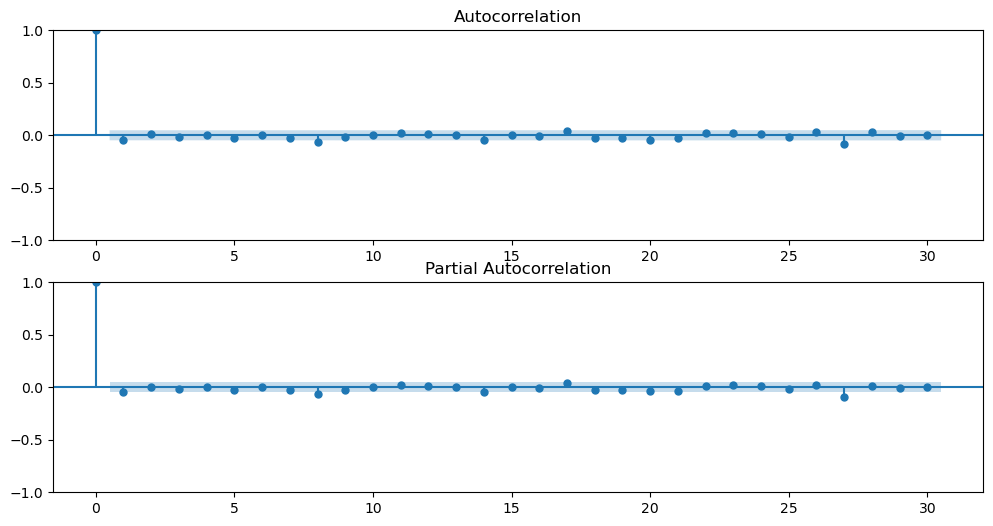

In [18]:
fig, axes = plt.subplots(2,1, figsize=(12,6))
plot_acf(at_diff, ax=axes[0], lags=30)
plot_pacf(at_diff, ax=axes[1], lags=30)
plt.show()


| ARIMA(p,d,q) | AIC | BIC | HQIC |
|--------------|-----|-----|------|
| (1,1,1) | -602.774 | **-586.433** | **-596.727** |
| (1,1,2) | -601.624 | -579.838 | -593.562 |
| (1,1,4) | -601.518 | -568.845 | -589.427 |
| (2,1,1) | -602.584 | -580.795 | -594.521 |
| (2,1,2) | **-606.124** | -578.891 | -596.046 |
| (2,1,4) | -599.988 | -561.871 | -585.882 |
| (4,1,1) | -602.296 | -569.620 | -590.204 |
| (4,1,2) | -600.408 | -562.286 | -586.300 |
| (4,1,4) | -599.797 | -550.788 | -581.660 |

**=> Chọn mô hình có AIC và HQIC nhỏ nhất => ARIMA(2,1,2)**


### 3.3. Kiểm tra tính phù hợp của mô hình

In [19]:
p, d, q = 1, 1, 1

model_arima = sm.tsa.ARIMA(
    arima_train,
    order=(p, d, q),
    trend='n',                    # giá cổ phiếu thường không cần constant khi d=1
    enforce_stationarity=False,   # tránh lỗi hội tụ
    enforce_invertibility=False
)

arima_fit = model_arima.fit()

print(arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1687
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 275.069
Date:                Mon, 12 Jan 2026   AIC                           -544.137
Time:                        13:27:03   BIC                           -527.851
Sample:                    01-02-2020   HQIC                          -538.105
                         - 08-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2337      0.430     -0.544      0.587      -1.076       0.609
ma.L1          0.1879      0.432      0.435      0.663      -0.659       1.034
sigma2         0.0422      0.001     73.698      0.0

**=> P-value > 0.05 => Mô hình được coi là không phù hợp**

In [20]:
p, d, q = 2, 1, 2

model_arima = sm.tsa.ARIMA(
    arima_train,
    order=(p, d, q),
    trend='n',                    # giá cổ phiếu thường không cần constant khi d=1
    enforce_stationarity=False,   # tránh lỗi hội tụ
    enforce_invertibility=False
)

arima_fit = model_arima.fit()

print(arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1687
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 274.507
Date:                Mon, 12 Jan 2026   AIC                           -539.013
Time:                        13:27:03   BIC                           -511.872
Sample:                    01-02-2020   HQIC                          -528.960
                         - 08-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5803      2.801     -0.207      0.836      -6.071       4.910
ar.L2          0.0337      1.199      0.028      0.978      -2.316       2.384
ma.L1          0.5345      2.801      0.191      0.8

**=> P-value < 0.05 => Mô hình ARIMA(2,1,2) được coi là phù hợp**

### 3.4. Dự báo

In [21]:
# Số bước dự báo = độ dài tập test
n_forecast = len(arima_test)

arima_pred = arima_fit.forecast(steps=n_forecast)
arima_pred.index = arima_test.index  # gán lại index thời gian

MAE: 2.2373
RMSE: 2.8896


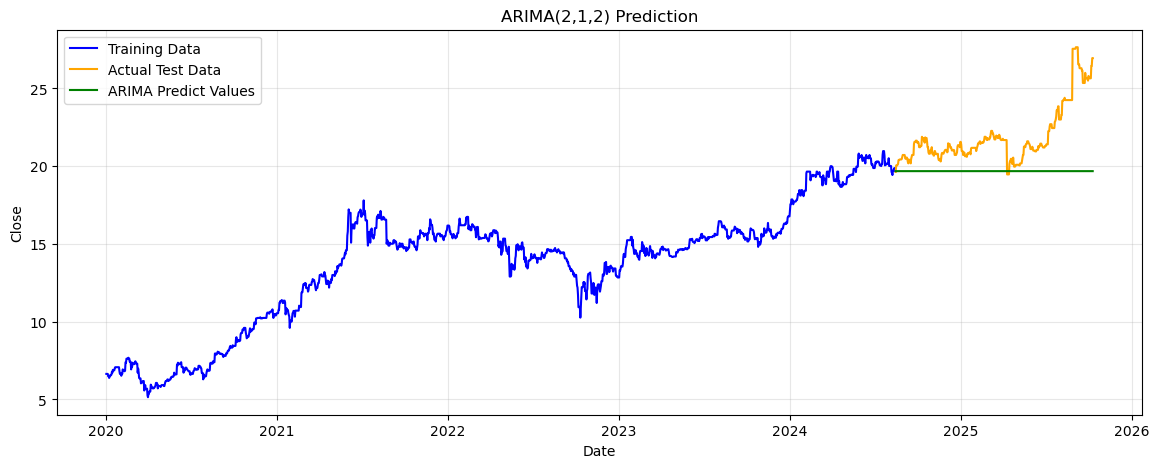

In [22]:
mae_arima = mean_absolute_error(arima_test, arima_pred)
rmse_arima = np.sqrt(mean_squared_error(arima_test, arima_pred))

print(f"MAE: {mae_arima:.4f}")
print(f"RMSE: {rmse_arima:.4f}")

plt.figure(figsize=(14,5))

plt.plot(arima_train, label='Training Data', color='blue')
plt.plot(arima_test, label='Actual Test Data', color='orange')
plt.plot(arima_pred, label='ARIMA Predict Values', color='green')

plt.title('ARIMA(2,1,2) Prediction')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

## 4. Dự đoán với LSTM
### 4.1. Chuẩn bị dữ liệu cho LSTM

In [23]:
ts2 = data.set_index('date')['close'].asfreq('D').ffill()

values = ts2.values.reshape(-1, 1)

lstm_train_size = int(len(values) * 0.8)

lstm_train = values[:lstm_train_size]
lstm_test  = values[lstm_train_size:]

print("Train size:", len(lstm_train))
print("Test size:", len(lstm_test))
lstm_train[:5], lstm_test[:5]

Train size: 1687
Test size: 422


(array([[6.64],
        [6.64],
        [6.64],
        [6.64],
        [6.49]]),
 array([[19.63],
        [20.05],
        [20.05],
        [20.05],
        [20.09]]))

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = scaler.fit_transform(lstm_train)
test_scaled  = scaler.transform(lstm_test)

**Chia chuỗi thành các nhóm dự đoán (sliding window)**

Mỗi input là 60 ngày giá đóng cửa, output là giá ngày tiếp theo.
(60 ngày là window size phổ biến để dự đoán xu hướng ngắn hạn)

In [25]:
def create_sequences(data, lookback=30):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

LOOKBACK = 30

X_train, y_train = create_sequences(train_scaled, LOOKBACK)
X_test, y_test   = create_sequences(test_scaled, LOOKBACK)


In [26]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1657, 30, 1) (1657,)
(392, 30, 1) (392,)


### 4.2. Xây dựng và huấn luyện mô hình
**Xây dựng mô hình LSTM với Keras**

In [27]:
# Build the Model
model_lstm = keras.models.Sequential()

**First Layer: This is like a brain to help the model understand patterns**
- Number 64: the number of memory cells. Higher number, the more complex problems
- return_sequence: after done, give me the full list of ideas for the next layer
- input_shape: tell the first LSTM layer what kind of date expect\
*=> The first LSTM layer learns patterns from past stock prices over time.*

In [28]:
# First Layer
model_lstm.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))

c:\Users\NGUYEN MINH TUYET\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Second Layer: This is another brain, but this time it only gives the final idea, not a list of thoughts**
- Number 64: the number of helpers to help the brain. Higher number, the more complex problems
- return_sequence: this tells the model to return a single output (the final prediction) instead of a sequence\
*=> This layer distills the important patterns form the first layer and prepares to make a final prediction.*

In [29]:
# Second Layer
model_lstm.add(keras.layers.LSTM(64, return_sequences=False))

**Dense Layer: turns complex patterns into a decision**
- Number 128: this is a regular neutral network layer with 128 neurons to help make the final decision
- activation: helps the model introduce non-linearity (ReLU - Rectified Linear Unit)\
*=> This layer helps the model adjust and refine its understanding of the data, learning more complicated trends.*

In [30]:
# 3rd Layer (Dense)
model_lstm.add(keras.layers.Dense(128, activation="relu"))

**Dropout Layout: This layer randomly drops out 50% of the neurons during training**
- Note: This prevents overfitting (when the model memorizes the data too well but struggies with new data).\
*=> It keeps the model from being too sensitive to the training data and makes it perform better*

In [31]:
# 4th Layer (Dropout)
model_lstm.add(keras.layers.Dropout(0.5))

**Final Dense Layer: This layer makes the final prediction**
- Note: a simple layer with 1 neuron that outputs one value - the predicted stock price.\
=> This is the layer that actually makes the prediction for the stock price

**Model Compilation: This compiles for the model to tell it how to learn. We are giving it information to improve**
- optimizer: Adam is a popular optimizer that helps the model adjust its learning. Works well with time-series data.
- loss: MAE measures how far the predictions are from the actual prices. The lower the MAE, the better.
- metrics: This is another performance metric that checks how accurate the predictions are.

In [32]:
# Final Output Layer
model_lstm.add(keras.layers.Dense(1))

model_lstm.summary()
model_lstm.compile(optimizer="adam",
              loss="mae",
              metrics=[keras.metrics.RootMeanSquaredError()])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

### 4.3. Kết Quả Huấn Luyện (Training)

In [33]:
training_resid = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.1567 - root_mean_squared_error: 0.2271
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0779 - root_mean_squared_error: 0.1065
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0702 - root_mean_squared_error: 0.0959
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0677 - root_mean_squared_error: 0.0907
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0621 - root_mean_squared_error: 0.0834
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0635 - root_mean_squared_error: 0.0864
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0641 - root_mean_squared_error: 0.0865
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0640 - root_mean_squared_error: 0.0867
Epoch 9/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0596 - root_mean_squared_error: 0.0802
Epoch 10/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0595 - root_mean_squared_error: 0.0800

### 4.4. Dự đoán

In [34]:
y_pred_scaled = model_lstm.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


In [35]:
y_pred_lstm = scaler.inverse_transform(y_pred_scaled)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

MAE: 0.5152
RMSE: 0.6228


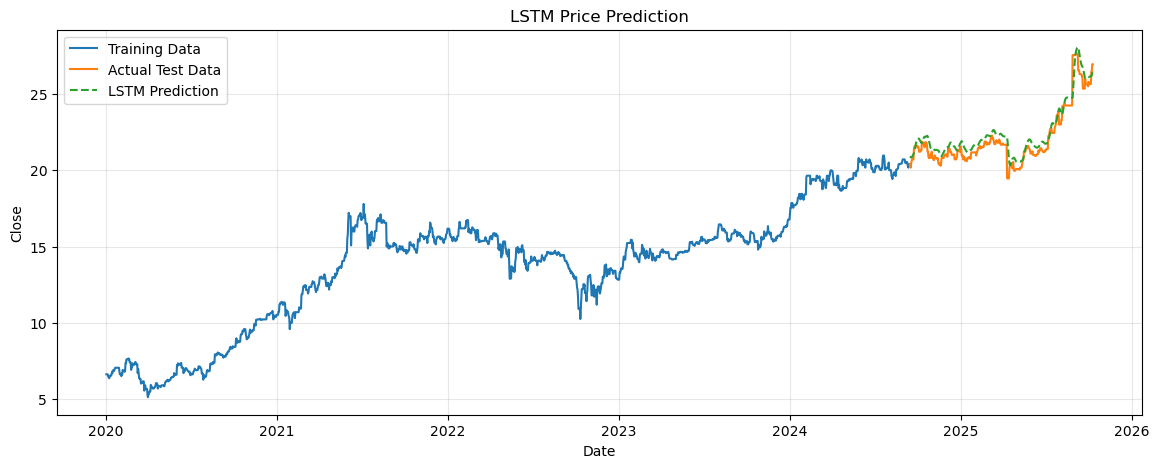

In [36]:
mae_lstm = mean_absolute_error(y_test_inv, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_lstm))

print(f"MAE: {mae_lstm:.4f}")
print(f"RMSE: {rmse_lstm:.4f}")

test_dates = ts.index[-len(y_test_inv):]
pred_dates = test_dates[-len(y_pred_lstm):]


plt.figure(figsize=(14,5))
train_end_date = ts.index[lstm_train_size + LOOKBACK]

plt.plot(
    ts.index[:lstm_train_size + LOOKBACK],
    ts.iloc[:lstm_train_size + LOOKBACK],
    label='Training Data'
)
plt.plot(test_dates, y_test_inv, label='Actual Test Data')
plt.plot(pred_dates, y_pred_lstm, label='LSTM Prediction', linestyle='--')

plt.title('LSTM Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 5. Dự đoán với Ensemble
### 5.1. Chuẩn bị dữ liệu

In [37]:
min_len = min(len(arima_pred), len(y_pred_lstm))

arima_pred = arima_pred[-min_len:]
y_pred_lstm = y_pred_lstm[-min_len:]


In [38]:
print(type(arima_pred), arima_pred.shape)
print(type(y_pred_lstm), y_pred_lstm.shape)

<class 'pandas.core.series.Series'> (392,)
<class 'numpy.ndarray'> (392, 1)


In [51]:
arima_pred_np = np.array(arima_pred).flatten()
lstm_pred_np  = np.array(y_pred_lstm).flatten()

# Trung bình có trọng số
w_arima = 0.2
w_lstm  = 0.8

y_ensemble = w_arima * arima_pred_np + w_lstm * lstm_pred_np

### 5.2. Dự báo

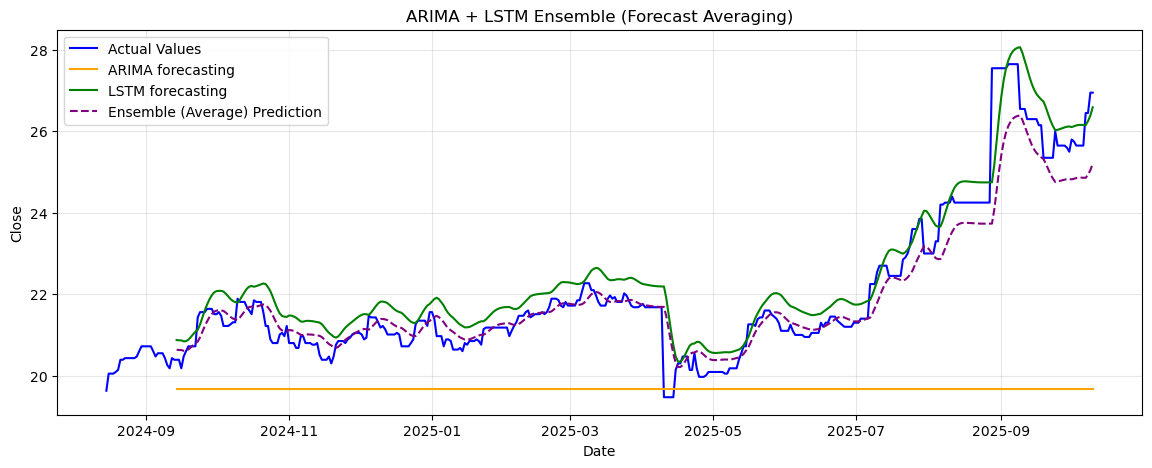

In [52]:
dates = arima_test.index[-len(y_ensemble):]

plt.figure(figsize=(14,5))
plt.plot(arima_test.index, arima_test.values, label='Actual Values', color="blue")
plt.plot(dates, arima_pred, label='ARIMA forecasting', color="orange")
plt.plot(dates, y_pred_lstm, label='LSTM forecasting', color="green")
plt.plot(dates, y_ensemble,'--', label='Ensemble (Average) Prediction', color="purple")

plt.title('ARIMA + LSTM Ensemble (Forecast Averaging)')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [53]:
y_true = arima_test.values

y_true      = y_true[-min_len:]
y_ensemble  = y_ensemble[-min_len:]

mae_ensemble = mean_absolute_error(y_true, y_ensemble)
rmse_ensemble = np.sqrt(mean_squared_error(y_true, y_ensemble))

print(f"Ensemble MAE : {mae_ensemble:.4f}")
print(f"Ensemble RMSE: {rmse_ensemble:.4f}")

Ensemble MAE : 0.3638
Ensemble RMSE: 0.5968


## 6. So sánh chỉ số

In [54]:
df_metrics = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM', 'Ensemble'],
    'MAE':   [mae_arima, mae_lstm, mae_ensemble],
    'RMSE':  [rmse_arima, rmse_lstm, rmse_ensemble]
})

df_metrics


,Model,MAE,RMSE
0,ARIMA,2.237256,2.889599
1,LSTM,0.515164,0.622764
2,Ensemble,0.363841,0.596839


**=> Kết luận: Mô hình Ensemble có hiệu suất tốt nhất với MAE và RMSE nhỏ nhất**